# Socioeconomic data and TOC entitlements
* Entitlements assigned to census tracts
* Which census tracts (what income levels or median household income) have seen TOC entitlements?
* See if tract is composed of mostly TOC-eligible parcels
* Then look at Census characteristics of mostly TOC-eligible tracts vs not

In [1]:
import boto3
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import pandas as pd

import laplan

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## A. Merge in number of TOC entitlements that tract had with census stats

In [3]:
# Download parcels with TOC entitlement info, and only keep parcels with TOC ent
def tracts_with_TOC_ent():    
    parcels = catalog.toc_parcels_with_entitlements.read().to_crs('EPSG:4326')
    toc_parcels = parcels[parcels.num_TOC > 0][['AIN', 'num_TOC', 'num_nonTOC']]

    crosswalk_parcels_tracts = catalog.crosswalk_parcels_tracts.read()
    
    df = pd.merge(crosswalk_parcels_tracts[["AIN", "GEOID", "toc_AIN"]], 
         toc_parcels, on = "AIN", how = "left", validate = "1:1")
    
    # Fill in NaNs with zeroes
    df = df.assign(
        num_TOC = df.num_TOC.fillna(0).astype(int),
        num_nonTOC = df.num_nonTOC.fillna(0).astype(int),
    )
    
    # Aggregate to tract-level
    df = (df.groupby(["GEOID", "toc_AIN"])
          .agg({"num_TOC": "sum", 
                "num_nonTOC": "sum"})
          .reset_index()
         )
    
    # Merge in census tract geometry and other census characteristics
    tracts = catalog.census_tracts.read().to_crs("EPSG:4326")
    census_stats = catalog.census_analysis_table.read()
    
    # Merge in census tract geometry with census stats
    census = pd.merge(tracts[["GEOID", "geometry"]], 
                      census_stats, 
                      on = "GEOID", how = "left", validate = "1:1")
    
    # Merge in census tract geometry with TOC entitlements
    final = pd.merge(census, df, on  = "GEOID", how = "left", validate = "1:1")
    
    return final

In [4]:
final = tracts_with_TOC_ent()

## B. Summary stats
Instead of unweighted averages, we should definitely weight by population. 
Aggregate counts for # non car, # zero veh workers, etc into the group first.
Then calculate % non car, % zero veh workers, medincome etc.

In [5]:
# Already have info whether tract is 50% or more (by area or # AIN) TOC-eligible
# Now add info about how many actual TOC entitlements occurred
def set_groups(df):
    def set_cutoffs(row):
        toc_ENT = 0
        toc_ENT_group = 0
        
        if row.num_TOC > 0: 
            toc_ENT = 1
            if row.num_TOC <= 5:
                toc_ENT_group = 1
            if (row.num_TOC > 5) and (row.num_TOC <= 10):
                toc_ENT_group = 2
            if row.num_TOC > 10:
                toc_ENT_group = 3
        
        return pd.Series([toc_ENT, toc_ENT_group], 
                         index=['toc_ENT', 'toc_ENT_group'])
    
    with_cutoffs = df.apply(set_cutoffs, axis=1)
    
    df = pd.concat([df, with_cutoffs], axis=1)
    
    df = df.assign(
        num_TOC = df.num_TOC.fillna(0).astype(int),
        num_nonTOC = df.num_nonTOC.fillna(0).astype(int),
    )
    
    return df

In [6]:
final = set_groups(final)
final.head(2)

,GEOID,geometry,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,...,total_r125to149,total_r150to199,total_gt200,total_total,density,toc_AIN,num_TOC,num_nonTOC,toc_ENT,toc_ENT_group
0,06037101110,"MULTIPOLYGON (((-118.29792 34.26322, -118.2969...",46,1927,0.023871,0,0.000000,2199,4219,0.521214,...,93,109,44,1596,9565.898824,0,0,0,0,0
1,06037101122,"MULTIPOLYGON (((-118.27742 34.25990, -118.2774...",11,1907,0.005768,8,0.004195,577,3234,0.178417,...,105,133,192,1256,3168.165623,0,0,0,0,0


In [7]:
# Calculate IQR for income
def aggregate_by_toc(df, category_col, income_df):
    df = df[["GEOID", category_col]]

    df2 = pd.merge(df, income_df, on = "GEOID", how = "left", validate = "1:1")

    # Aggregate by toc_area or toc_AIN
    df2 = df2.pivot_table(index = category_col, aggfunc = "sum").reset_index()
    
    # Calculate IQR
    iqr = (df2.apply(
            lambda r: pd.Series(laplan.census.income_percentiles(r, [25,50,75]), dtype="float64"),
            axis=1,
        ).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})
    )
    
    # Change unit income IQR from thousands of dollars to dollars
    DOLLAR_UNIT = 1_000
    
    iqr = (iqr.assign(
            Q1 = iqr.Q1 * DOLLAR_UNIT,
            Q2 = iqr.Q2 * DOLLAR_UNIT, 
            Q3 = iqr.Q3 * DOLLAR_UNIT,
        ).rename(columns = {"Q1": "income_Q1", 
                            "Q2": "income_Q2", 
                            "Q3": "income_Q3"})
    )

    # Merge IQR in
    df3 = pd.merge(df2[[category_col]], iqr, left_index = True, right_index = True, 
                   how = "left", validate = "1:1")
    
    return df3

def summary_stats(df, category_col, income_df):
    # Number of tracts by cut-offs
    num_tracts = (df.groupby(category_col).agg({
            "GEOID": "count"
        }).reset_index()
            .rename(columns = {"GEOID": "num_tracts"})
    )
    
    # Calculate totals
    totals = df.groupby(category_col).agg({
            "zero_veh_workers": "sum",
            "non_car_workers": "sum",
            "workers_total": "sum",
            "pop_renter": "sum",
            "pop_whitenonhisp": "sum",
            "pop_total": "sum",
    }).reset_index()
    
    # Calculate percents
    percents = totals.assign(
        pct_zero_veh = totals.zero_veh_workers / totals.workers_total,
        pct_non_car = totals.non_car_workers / totals.workers_total,
        pct_renter = totals.pop_renter / totals.pop_total,
        pct_white = totals.pop_whitenonhisp / totals.pop_total,
    )
    
    # Calculate income IQR
    income_iqr = aggregate_by_toc(df, category_col, income_df)
    
    # Create final table
    summary = pd.merge(percents, num_tracts, on = category_col, validate = "1:1")
    summary = pd.merge(summary, income_iqr, on = category_col, validate = "1:1")
    
    return summary

In [8]:
# Create a subset df that pulls out incomerange columns from census stats
income_ranges = laplan.census.CENSUS_INCOME_RANGES

# The new_var columns to keep all have prefix "total_". 
# Can switch out if we're interested in other races' income ranges
keep = []
for x in income_ranges:
    keep.append("total_" + x)

keep.append("GEOID")

census_stats = catalog.census_analysis_table.read()
income = census_stats[keep]

income.head(2)

,total_lt10,total_r10to14,total_r15to19,total_r20to24,total_r25to29,total_r30to34,total_r35to39,total_r40to44,total_r45to49,total_r50to59,total_r60to74,total_r75to99,total_r100to124,total_r125to149,total_r150to199,total_gt200,total_total,GEOID
0,110,97,70,76,123,96,54,78,88,64,126,277,91,93,109,44,1596,06037101110
1,52,18,0,15,39,38,7,40,23,62,186,232,114,105,133,192,1256,06037101122


In [9]:
# TOC tracts: 50% of AIN in TOC Tier or not
by_AIN = summary_stats(final, "toc_AIN", income)
by_AIN

,toc_AIN,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,40670,108515,1286530,1231352,979103,2590475,0.031612,0.084347,0.475338,0.377963,639,34833.482130,73725.802883,136571.486262
1,1,89382,184834,972028,1408106,391433,1941391,0.091954,0.190153,0.725308,0.201625,510,22374.903705,47143.378227,90803.213199


In [10]:
# TOC tracts: has TOC ENT or not
by_toc_ENT = summary_stats(final, "toc_ENT", income)
by_toc_ENT

,toc_ENT,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91893,220391,1912103,2140958,1205165,3888795,0.048059,0.115261,0.550545,0.309907,973,29209.422510,63622.868743,120427.208869
1,1,38159,72958,346455,498500,165371,643071,0.110141,0.210584,0.775187,0.257158,176,23553.373441,49107.689951,93826.487650


In [11]:
# TOC tracts: by number of TOC ENT
by_num_TOC_ENT = summary_stats(final, "num_TOC", income)
by_num_TOC_ENT

,num_TOC,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91893,220391,1912103,2140958,1205165,3888795,0.048059,0.115261,0.550545,0.309907,973,29209.422510,63622.868743,120427.208869
1,1,16791,30420,141555,205654,69242,270279,0.118618,0.214899,0.760895,0.256187,77,22499.240929,47817.159299,93349.558795
2,2,8530,16674,71861,102083,32611,130372,0.118701,0.232031,0.783013,0.250138,36,24968.100189,50746.735582,96293.209877
3,3,4196,8148,42141,62534,18865,76958,0.099570,0.193351,0.812573,0.245134,19,22884.284309,44662.678208,86847.198761
4,4,2311,4452,21556,28124,11842,38921,0.107209,0.206532,0.722592,0.304257,12,25346.627409,52962.489344,98723.454091
5,5,528,1390,8498,13945,3876,16951,0.062132,0.163568,0.822665,0.228659,5,20053.353659,39424.504950,74689.597315
6,6,1514,3168,18994,25565,8970,32628,0.079709,0.166790,0.783529,0.274917,8,27726.293103,57334.004024,106258.596974
7,7,637,1392,7436,11331,4128,14335,0.085664,0.187197,0.790443,0.287967,4,26520.408163,53429.844098,97679.765886
8,8,2042,3751,14654,22978,4625,27796,0.139348,0.255971,0.826666,0.166391,7,19631.837307,40962.343096,71230.736301
9,9,143,626,3772,4771,2225,5650,0.037911,0.165960,0.844425,0.393805,1,41618.150685,76109.601449,112253.584229


In [12]:
# TOC tracts: by grouping the number of TOC ENT into 3 groups
# 0: num_TOC = 0
# 1: 1-5
# 2: 6-10
# 3: 11+
by_TOC_ENT_group = summary_stats(final, "toc_ENT_group", income)
by_TOC_ENT_group

,toc_ENT_group,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91893,220391,1912103,2140958,1205165,3888795,0.048059,0.115261,0.550545,0.309907,973,29209.422510,63622.868743,120427.208869
1,1,32356,61084,285611,412340,136436,533481,0.113287,0.213871,0.772923,0.255747,149,23250.494748,48213.537172,93011.332974
2,2,5301,10708,53544,77991,23825,96590,0.099003,0.199985,0.807444,0.246661,24,24437.449228,50961.538462,94114.126097
3,3,502,1166,7300,8169,5110,13000,0.068767,0.159726,0.628385,0.393077,3,37121.478873,74238.461538,132467.296512


In [13]:
if not os.path.exists("../outputs"):
    os.mkdir("../outputs")
writer = pd.ExcelWriter("../outputs/07-toc-census-stats.xlsx", engine="xlsxwriter")

by_AIN.to_excel(writer, sheet_name = "by_pct_AIN")
by_toc_ENT.to_excel(writer, sheet_name = "by_TOC_ENT")
by_num_TOC_ENT.to_excel(writer, sheet_name = "by_num_TOC_ENT")
by_TOC_ENT_group.to_excel(writer, sheet_name = "by_TOC_ENT_group")

writer.save()

## C. Make map of tracts

<AxesSubplot:title={'center':'TOC Tracts by % AIN'}>

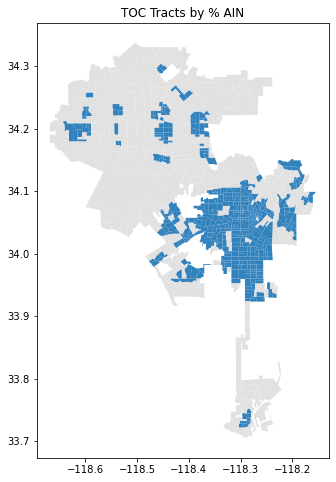

In [14]:
# By AIN
final = final.to_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by % AIN")

blue = "#3182BD"
gray = "#E1E1E1"
final.plot(column="toc_AIN", ax=ax, 
           cmap = matplotlib.colors.ListedColormap([gray, blue]), 
           legend=False)

<AxesSubplot:title={'center':'TOC Tracts by having TOC Entitlements'}>

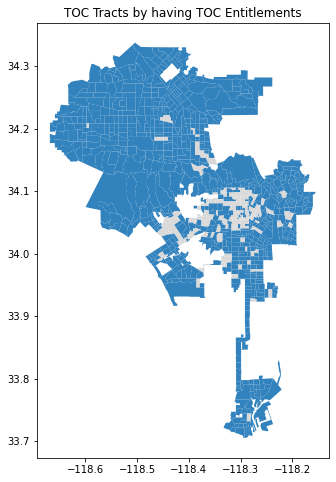

In [15]:
# By TOC ENT
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by having TOC Entitlements")
final.plot(column="toc_ENT", ax=ax, cmap = "tab20c", legend=False)

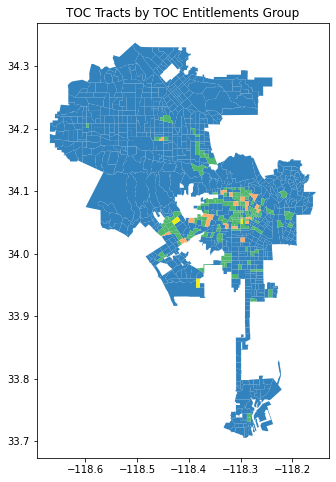

In [16]:
# By TOC ENT group
colors = {0: '#3182bd', # blue
          1: '#50b76f', # green
          2: '#fdae6b', # orange
          3: '#eded0f'} # yellow

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by TOC Entitlements Group")

for ctype, data in final.groupby('toc_ENT_group'):
    
    # Define the color for each group using the dictionary
    color = colors[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype, 
              legend=True)